In [29]:
import numpy as np
import astropy.io.ascii as at
import matplotlib.pyplot as plt
%matplotlib inline
from astroML import time_series

import hypra.prot.fix_kepler
import hypra.prot.time_series

from k2spin import lc
from k2spin import k2io
from k2spin import plot

First, read in the lightcurve and run necessary corrections

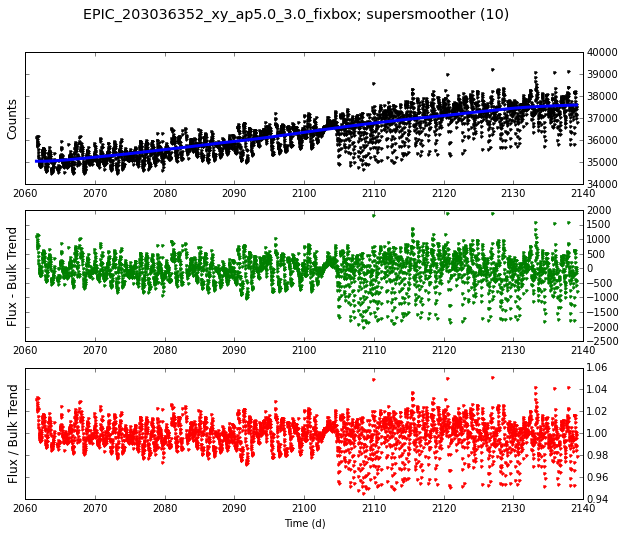

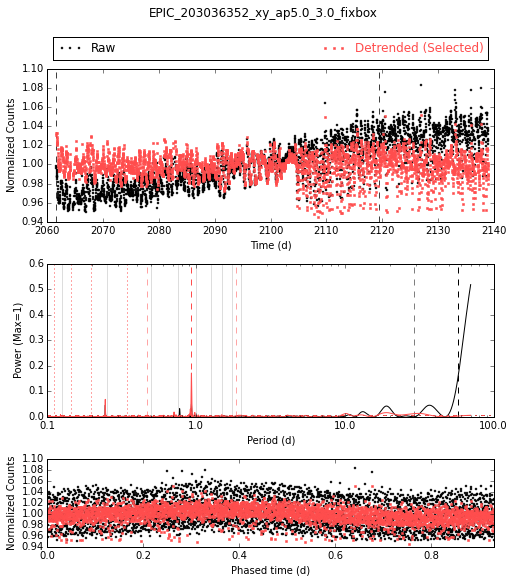

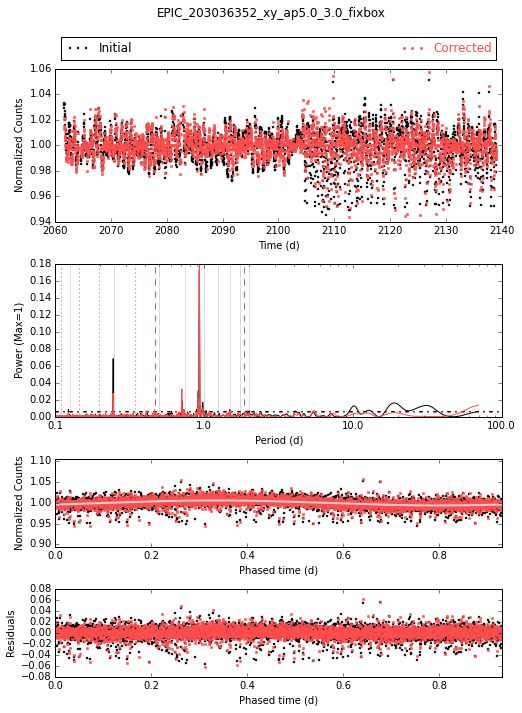

In [30]:
lc_dir = "/home/stephanie/code/python/k2spin/lcs/"
#filename = "EPIC_202521690_xy_ap5.0_3.0_fixbox.dat"
#filename = "EPIC_202593561_xy_ap5.0_3.0_fixbox.dat"
#filename = "EPIC_202585030_xy_ap5.0_3.0_fixbox.dat"
#filename = "EPIC_203033414_xy_ap5.0_3.0_fixbox.dat"
#filename = "EPIC_202533810_xy_ap5.0_3.0_fixbox.dat"
filename = "EPIC_203036352_xy_ap5.0_3.0_fixbox.dat"
#filename = "EPIC_20_xy_ap5.0_3.0_fixbox.dat"

lc_out = k2io.read_double_aperture(lc_dir+filename)
time, fluxes, unc_fluxes, x_pos, y_pos, qual_flux, apertures = lc_out
    
light_curve = lc.LightCurve(time, fluxes[1], unc_fluxes[1], x_pos, y_pos,
                            name=filename[:-4], 
                            detrend_kwargs={"kind":"supersmoother","phaser":10})
light_curve.choose_initial()
light_curve.correct_and_fit()


t = light_curve.time
y = light_curve.flux
dy = light_curve.unc_flux


Test the Edelson-Krolik modified ACF on the raw lightcurve

In [31]:
C_EK, C_EK_err, bins = time_series.ACF_EK(t, y, y,
                                          bins=np.linspace(0,70,400)
                                          )
t_EK = 0.5 * (bins[1:] + bins[:-1])

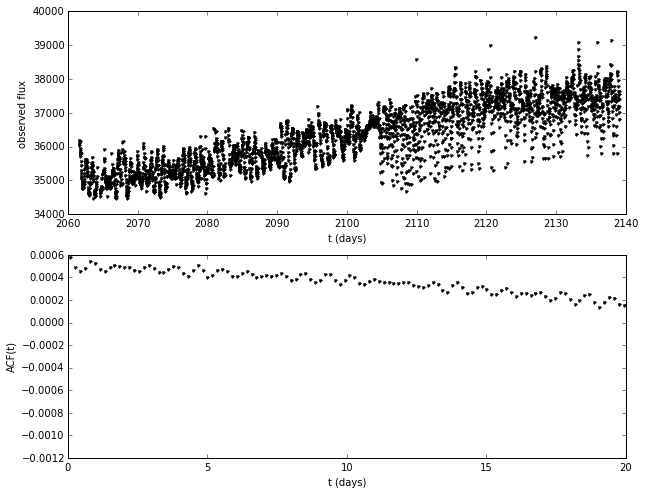

In [32]:
# Plot the results
fig = plt.figure(figsize=(10, 8))

# plot the input data
ax = fig.add_subplot(211)
#ax.errorbar(t, y, dy, fmt='.k', lw=1)
ax.plot(t, y,'k.', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.plot(t_EK, C_EK, 'k.', lw=1)
ax.set_xlim(0, 20)
#ax.set_ylim(-0.003, 0.003)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')


That _looks_ nice, but that's a teeny tiny value for the ACF *and* the errors obliterate it :/

Now try it with the flux that's been position-corrected

In [33]:
t = light_curve.time
y = light_curve.corrected_flux
dy = light_curve.corrected_unc

In [34]:
C_EK, C_EK_err, bins = time_series.ACF_EK(t, y, y,
                                          bins=np.linspace(0,70,400)
                                          )
t_EK = 0.5 * (bins[1:] + bins[:-1])

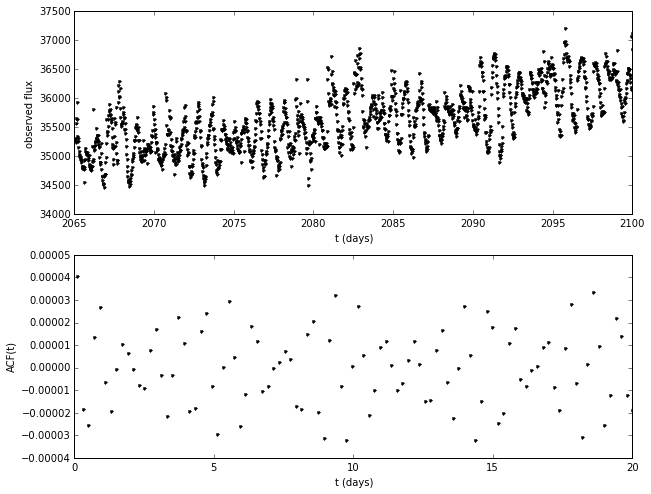

In [43]:
# Plot the results
fig = plt.figure(figsize=(10, 8))

# plot the input data
ax = fig.add_subplot(211)
#ax.errorbar(t, y, dy, fmt='.k', lw=1)
ax.plot(t, y,'k.', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.plot(t_EK, C_EK, 'k.', lw=1)
ax.set_xlim(0, 20)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

Out of curiosity, what happens if I crop the lightcurve?

In [36]:
t = light_curve.time
y = light_curve.corrected_flux[(t>2065) & (t<2100)]
dy = light_curve.corrected_unc[(t>2065) & (t<2100)]
t = t[(t>2065) & (t<2100)]

In [37]:
C_EK, C_EK_err, bins = time_series.ACF_EK(t, y, y,
                                          bins=np.linspace(0,40,200)
                                          )
t_EK = 0.5 * (bins[1:] + bins[:-1])

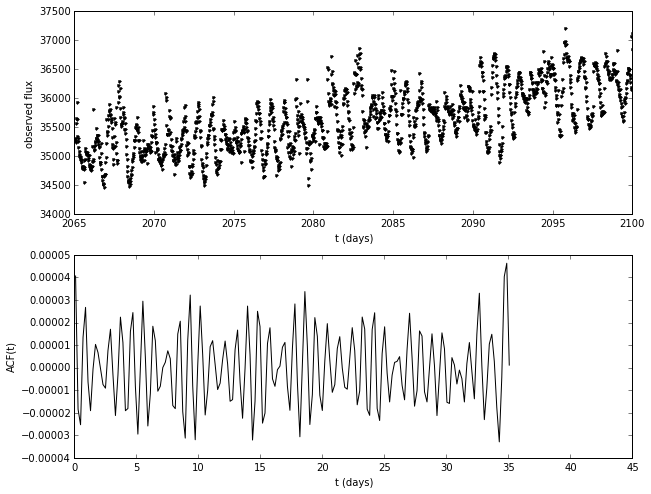

In [44]:
# Plot the results
fig = plt.figure(figsize=(10, 8))

# plot the input data
ax = fig.add_subplot(211)
#ax.errorbar(t, y, dy, fmt='.k', lw=1)
ax.plot(t, y,'k.', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.plot(t_EK, C_EK, 'k-', lw=1)
ax.set_xlim(0, 45)
#ax.set_ylim(-0.003, 0.003)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

What about filling the gaps?

In [39]:
cadence = np.median(np.diff(t))
print cadence

0.0204317899997


1.9205844999733017

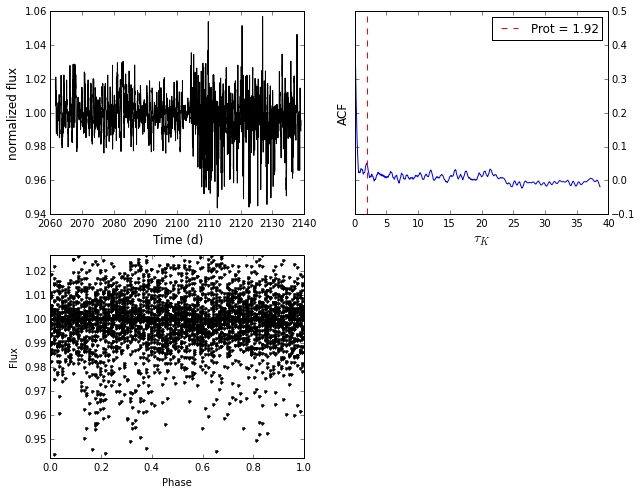

In [40]:
t, y, dy = hypra.prot.fix_kepler.fill_gaps(light_curve.time,
                                           light_curve.corrected_flux,
                                           light_curve.corrected_unc)
hypra.prot.time_series.run_acf(t, y, plot=True)

So it looks nice when applied to the corrected lc....

Let's try the raw lightcurve

21.330746999703479

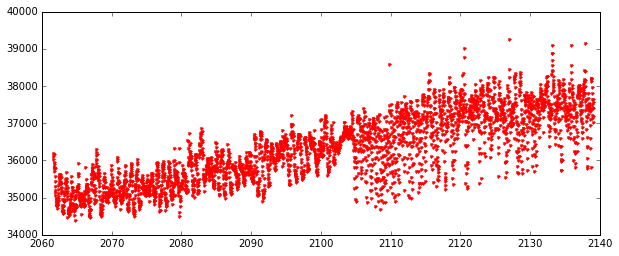

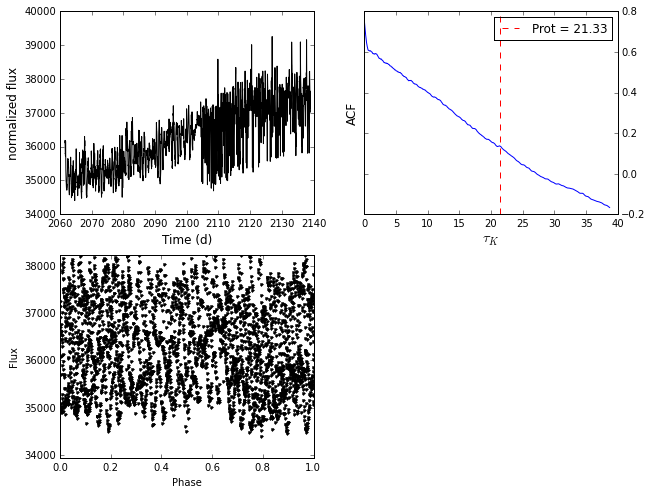

In [41]:
t, y, dy = hypra.prot.fix_kepler.fill_gaps(light_curve.time,
                                           light_curve.flux,
                                           light_curve.unc_flux)
plt.figure(figsize=(10,4))
plt.plot(t,y,'r.')
hypra.prot.time_series.run_acf(t, y, plot=True)

Not so much (though I can see the correct peak, it's just not being selected, so maybe my ACF code just needs more optimization than I made time for last fall)

I am heartened by the fact that the 6-hour period is not showing up as the dominant correlation lag, though the jagged shape does change sufficiently enough that maybe that should be less surprising.

One more! Just that subsection again

2.6969949599806569

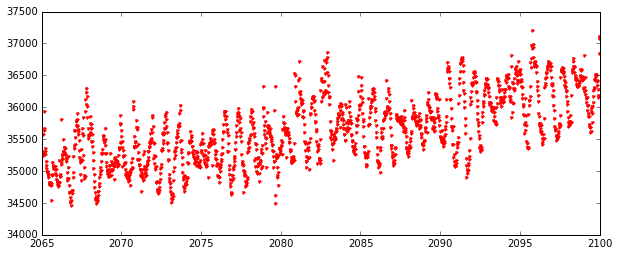

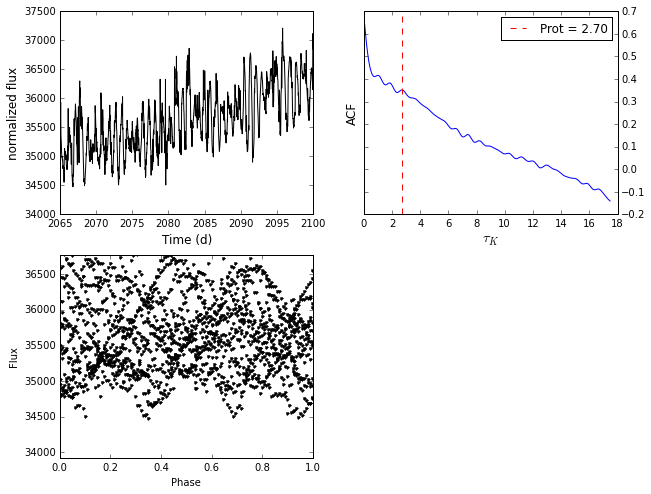

In [42]:
y = y[(t>2065) & (t<2100)]
dy = dy[(t>2065) & (t<2100)]
t = t[(t>2065) & (t<2100)]

plt.figure(figsize=(10,4))
plt.plot(t,y,'r.')
hypra.prot.time_series.run_acf(t, y, plot=True)

This seems to be an optimization issue again, because although there is that little bump at 3 days the ~6d peak is more significant